1. I notice that both in Jalaj and my code we didn't threshold GC after iters; in principle it shouldn't be smaller than theta > bc our projected gradient will ensure that all projected grad that resulted < theta, all go to zero; but to be 100% sure need to check again

2. let's plot some GC/MC properties over time:
    1. sparsification (# of responsive, # of divergent)
    2. yes distance/discrimination etc

<bv/>

3. why the connection is small (eventual)? how my threshold is in action?

5. we don't have epsilon either?

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy

In [3]:
import utils, math_utils, sir_model
import sir_model

In [31]:
# very sparse, as 0.05 gives us on average every GC connects to 5 MC.
M, N, p_conn = 10, 750, 0.05
max_lim = 0.5 # for each Wnm, the max connection strength

W = utils.create_network(M, N, p_conn, max_lim)

# matrix that has the same starting connection,
# but allowed to change while we keep a copy of W
W_easy = copy.deepcopy(W)
W_hard = copy.deepcopy(W)

Max number of non zero GC connections 4
Average number of non zero GC connections 0.5226666666666666
Max strength of GC connections 1.0
Average strength of GC connections 0.13554034661080624


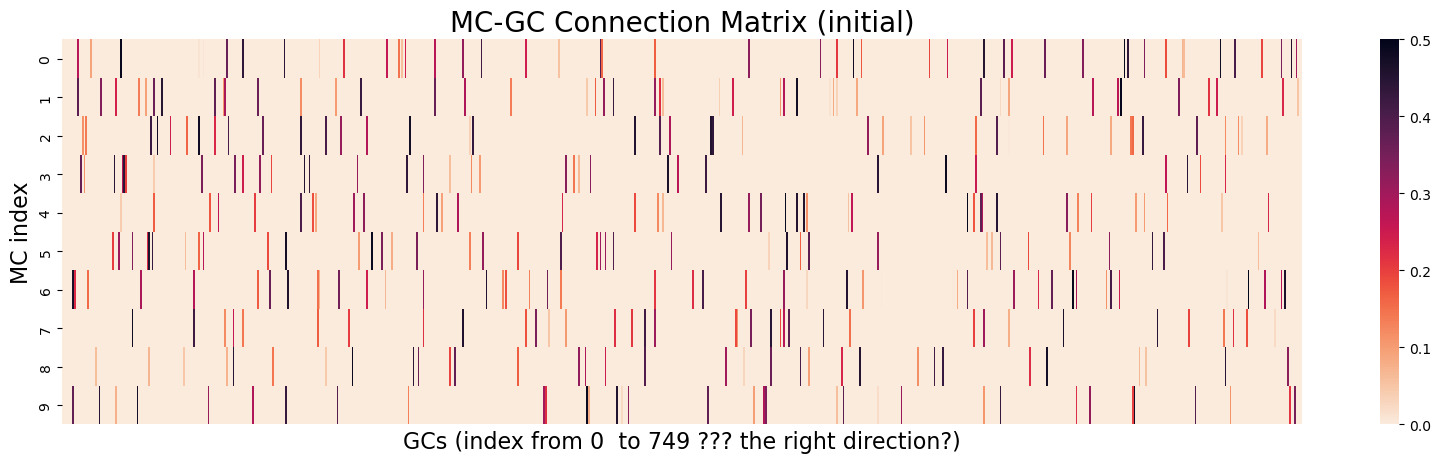

In [32]:
fig, ax = plt.subplots(figsize = (20, 5))
sns.heatmap(W, cmap = 'rocket_r',  xticklabels=False, vmin = 0 , vmax = max_lim)
ax.set_xlabel('GCs (index from 0  to 749 ??? the right direction?)', fontsize = 16)
ax.set_ylabel('MC index', fontsize = 16)
ax.set_title('MC-GC Connection Matrix (initial)', fontsize = 20)
plt.show()
# fig.savefig('plots/seed_2023_W_matrix.pdf')

Create odors (quadratic toy)

In [6]:
list1 = np.linspace(0.01, 1, M)
odor1 = [x**2 for x in list1]
odor2 = [x**2 for x in list1[::-1]]
odors_easy = np.array([odor1, odor2]).T

theta = .3
GC_responpse_easy = utils.get_GCact(W, odors_easy, theta)
GC_responpse_easy_init = copy.deepcopy(GC_responpse_easy)

In [7]:
(GC_responpse_easy_init[:, 0] != 0).sum()

34

In [8]:
(GC_responpse_easy_init[:, 1] != 0).sum()

39

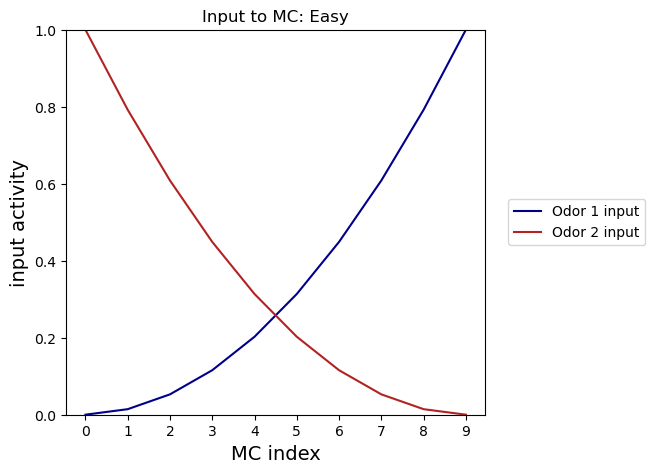

In [9]:
fig, ax = plt.subplots(figsize = (6,5))
plt.plot(odors_easy[:, 0], color = 'darkblue', label = 'Odor 1 input')
plt.plot(odors_easy[:, 1], color  = 'firebrick', label = 'Odor 2 input')
plt.xticks(list(range(10)))
ax.set_xlabel('MC index', fontsize = 14)
ax.set_ylabel('input activity', fontsize = 14)
ax.set_title('Input to MC: Easy')
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
ax.legend(loc='center right', bbox_to_anchor=(1.4, 0.5))
ax.set_ylim([0, 1])
plt.show()

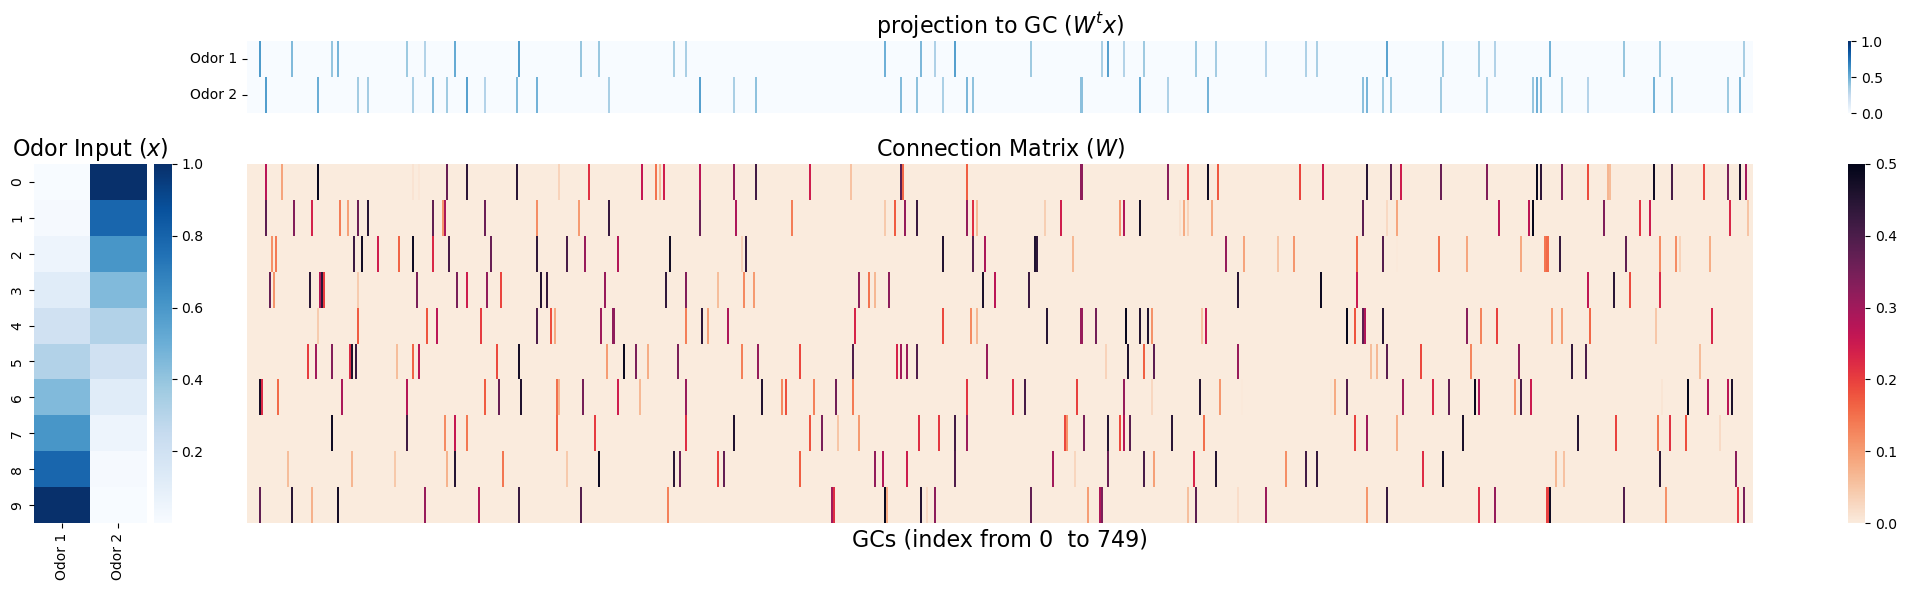

In [10]:
import matplotlib.gridspec as gridspec
from IPython.display import clear_output

# Create a 2x2 grid layout
fig = plt.figure(figsize=(21.5, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[1.5, 20], height_ratios=[1, 5])

# Create the subplots
# ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

# Create some sample data
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)

# sns.heatmap(GC_responpse.T, cmap = 'rocket_r')

# Plot some data in each subplot
# ax0.plot(x, y1, 'r')
# ax0.set_title('Top Left')

sns.heatmap(GC_responpse_easy_init.T, cmap = 'Blues', yticklabels= ['Odor 1', 'Odor 2'],  xticklabels= False, vmin = 0, vmax = 1,ax = ax1)
ax1.set_title('projection to GC ($W^{t}x$)', fontsize = 16)

sns.heatmap(odors_easy, cmap = 'Blues', xticklabels= ['Odor 1', 'Odor 2'], ax = ax2)
ax2.set_title('Odor Input ($x$)', fontsize = 16)

sns.heatmap(W, cmap = 'rocket_r',  xticklabels=False,  yticklabels= False, vmin = 0 , vmax = max_lim, ax = ax3)
ax3.set_xlabel('GCs (index from 0  to 749)', fontsize = 16)
ax3.set_title('Connection Matrix ($W$)',  fontsize = 16)

plt.tight_layout()
plt.show()

# fig.savefig('plots/easy_toy_init.pdf')


In [11]:
etas = {'associate': 0.005, 
        'disassociate':0.005, 
        'forget':0.0005}

In [12]:
K = 500 # each odor to be sniffed 500 times
# it seems a lot but the very first few very quickly determines the GC candidates to be changed 
# it can be imagined that the later pasticity doesn't even need the full matrix at all
# so it is computationally efficient, but still seems to require the input to be present

def main(W_pastic, odors, theta, K):
    GC_act = utils.get_GCact(W, odors, theta)

    GC_act_1 = GC_act[:,0] 
    GC_act_2 = GC_act[:,1] 

    odor1 = odors[:, 0]
    odor2 = odors[:, 1]

    GC_acts_overtime = np.zeros((K, W_pastic.shape[1], 2))
    MC_errs_overtime = np.zeros((K, W_pastic.shape[0], 2))

    W_overtime = np.zeros(((K*2, W_pastic.shape[0], W_pastic.shape[1])))

    for k in range(K):

        # sniff odor1:
        GC_act_1 = sir_model.sniff_cycle(odor1, GC_act_1, theta, W_pastic)
        MC_err_1 = sir_model.get_err(GC_act_1, odor1, W_pastic)
        sir_model.hebbian_update(W_pastic, GC_act_1, odor1, etas, cap = True, cap_strength = 1)
        GC_acts_overtime[k, :, 0] = GC_act_1
        MC_errs_overtime[k, :, 0] = MC_err_1    
        W_overtime[2*k] = copy.deepcopy(W_pastic)

        # sniff odor1:
        GC_act_2 = sir_model.sniff_cycle(odor2, GC_act_2, theta, W_pastic)
        MC_err_2 = sir_model.get_err(GC_act_2, odor2, W_pastic)
        sir_model.hebbian_update(W_pastic, GC_act_2, odor2, etas, cap = True, cap_strength = 1)  
        GC_acts_overtime[k, :, 1] = GC_act_2
        MC_errs_overtime[k, :, 1] = MC_err_2
        W_overtime[2*k + 1] = copy.deepcopy(W_pastic)

    return GC_acts_overtime, MC_errs_overtime, W_overtime

In [13]:
K = 500
GC_acts_overtime_easy, MC_errs_overtime_easy, W_overtime_easy =  main(W_easy, odors_easy, theta, K) 

In [17]:
def plot_learning(GC, MC, W, t, odor_type = 'Odor'):

    plt.figure(figsize=(21.5, 6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1.5, 20], height_ratios=[1, 5])

    # Create the subplots
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])
    ax3 = plt.subplot(gs[3])

    sns.heatmap(GC.T, cmap = 'Blues', yticklabels= [f'{odor_type} 1', f'{odor_type} 2'],  xticklabels= False, vmin = 0, vmax = 1,ax = ax1)
    ax1.set_title('projection to GC ($W^{t}x$)', fontsize = 16)

    sns.heatmap(MC, cmap = 'Blues', xticklabels= [f'{odor_type} 1', f'{odor_type} 2'],  vmin = 0, vmax = 1, ax = ax2)
    ax2.set_title('MC error ($r$)', fontsize = 16)

    sns.heatmap(W, cmap = 'rocket_r',  xticklabels=False,  yticklabels= False, vmin = 0 , vmax = max_lim, ax = ax3)
    ax3.set_xlabel('GCs (index from 0  to 749)', fontsize = 16)
    ax3.set_title('Connection Matrix ($W$)',  fontsize = 16)

    plt.suptitle(f't= {t}', fontsize = 18)
    
    plt.tight_layout()
    plt.show()

In [33]:
GC_counts_overtime = math_utils.active_GC_counts_overtime(GC_acts_overtime_easy)

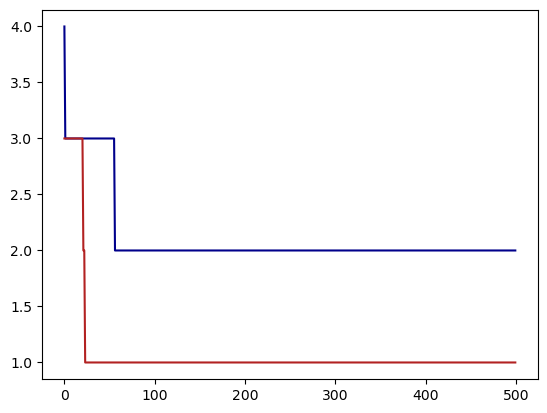

In [35]:
plt.plot(GC_counts_overtime[:, 0],color = 'darkblue', label = 'Odor 1 input')
plt.plot(GC_counts_overtime[:, 1], color  = 'firebrick', label = 'Odor 2 input')
plt.show()

In [36]:
# number of responsive neurons
responsive_counts = []
for i in range(K//2):
    MC_errs_bool = MC_errs_overtime_easy[i] > 0
    count = sum([MC_errs_bool[i, 0] or MC_errs_bool[i, 1] for i in range(M)])
    responsive_counts.append(count)

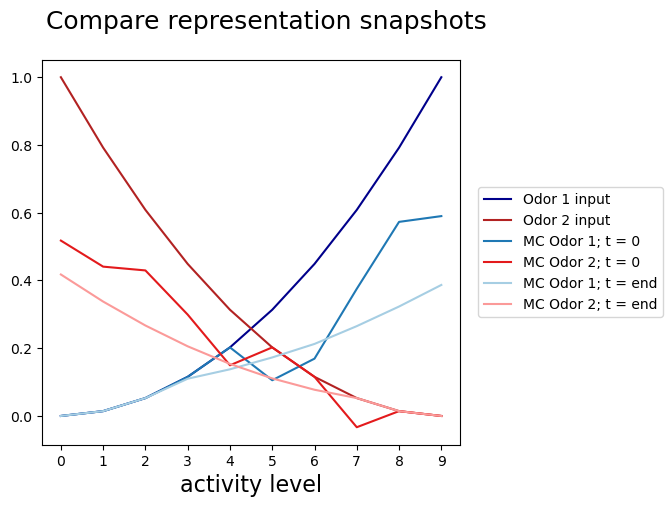

In [44]:
fig, ax = plt.subplots(figsize = (6,5))
plt.plot(odors_easy[:, 0], color = 'darkblue', 
         label = 'Odor 1 input')
plt.plot(odors_easy[:, 1], color  = 'firebrick', 
         label = 'Odor 2 input')

plt.plot(MC_errs_overtime_easy[0,:, 0], 
         label = 'MC Odor 1; t = 0', 
         color = sns.color_palette("Paired")[1])
plt.plot(MC_errs_overtime_easy[0,:, 1], 
         label = 'MC Odor 2; t = 0', 
         color = sns.color_palette("Paired")[5])

plt.plot(MC_errs_overtime_easy[499,:, 0], 
         label = 'MC Odor 1; t = end',
         color = sns.color_palette("Paired")[0])
plt.plot(MC_errs_overtime_easy[499,:, 1],  
         label = 'MC Odor 2; t = end', 
         color = sns.color_palette("Paired")[4])

plt.xticks(list(range(10)))
plt.xlabel('MC index', fontsize = 16)
plt.xlabel('activity level', fontsize = 16)

pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.suptitle('Compare representation snapshots', fontsize = 18)
plt.show()

fig.savefig('snapshots_easy.pdf')

there are interesting glitches -- perhaps due to dropping off of some GC cells (yes I think so)

In [47]:
# sns.lineplot(MC_errs_overtime_easy[:,:, 0], dashes = False, palette = 'flare')
# plt.show()

In [50]:
# sns.lineplot(MC_errs_overtime_easy[:,:, 1], dashes = False, palette = 'crest_r')
# plt.show()

**Divergent**: response difference increases

for each neuron:
- abs(response_diff) (t+1) abs(response_diff) (t)

In [38]:
# # number of divergent neurons 
# div_threshold = .2 ### this is not meaningful, placeholding
# sum(np.abs(MC_errs_overtime[0,:, 0] - MC_errs_overtime[0,:, 1]) > div_threshold)

7

In [51]:
absolute_diff = np.abs(MC_errs_overtime_easy[:,:, 0] - MC_errs_overtime_easy[:,:, 1])

In [52]:
absolute_diff.shape

(500, 10)

Don't know if order matches the color?

/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

<Axes: >

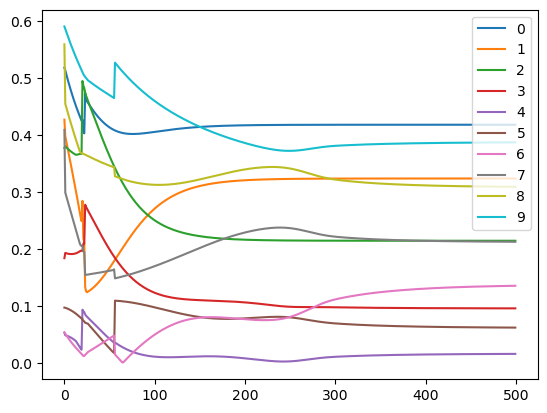

In [53]:
sns.lineplot(absolute_diff, dashes = False)

In [54]:
absolute_diff[0]- absolute_diff[-1]

array([ 0.10003476,  0.10311693,  0.16260265,  0.08805074,  0.03696682,
        0.03502979, -0.08152073,  0.19624385,  0.24986232,  0.20321596])

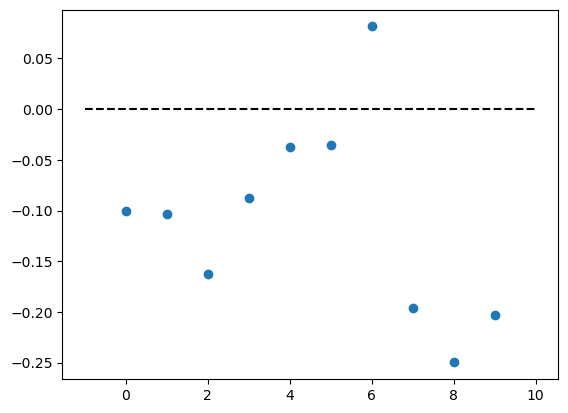

In [55]:
plt.scatter(list(range(M)), absolute_diff[-1]- absolute_diff[0])
plt.hlines(y = 0, xmin = -1, xmax = 10, linestyle = '--', color = 'black')

What does `deepcopy` actually do lol why `W_easy` didn't get changed

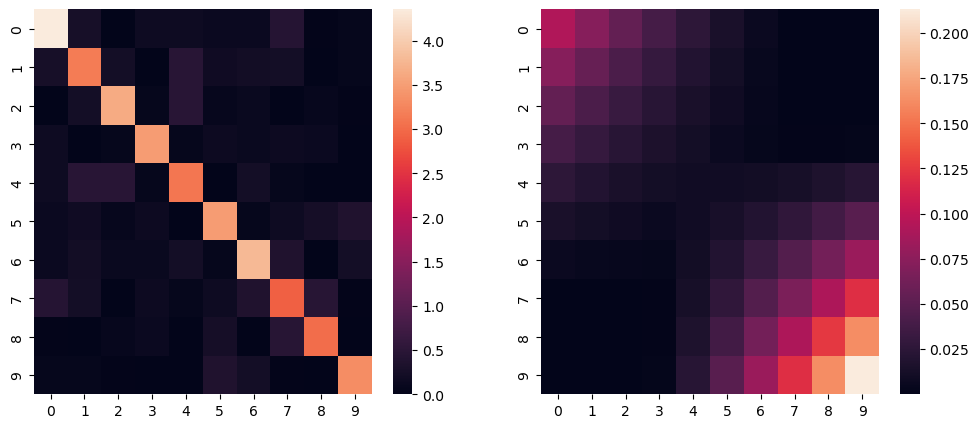

In [63]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 5))
sns.heatmap(W@W.T, ax = ax[0])
sns.heatmap(W_overtime_easy[-1]@W_overtime_easy[-1].T, ax = ax[1])
plt.show()

---

## Hard case

In [15]:
odor_mix1 = 0.60*np.array(odor1) + 0.40*np.array(odor2)
odor_mix2 = 0.40*np.array(odor1) + 0.60*np.array(odor2)

odor_mixes = np.array([odor_mix1, odor_mix2]).T

theta = .3
GC_responpse_hard = utils.get_GCact(W, odor_mixes, theta)
GC_responpse_hard_init = copy.deepcopy(GC_responpse_hard)

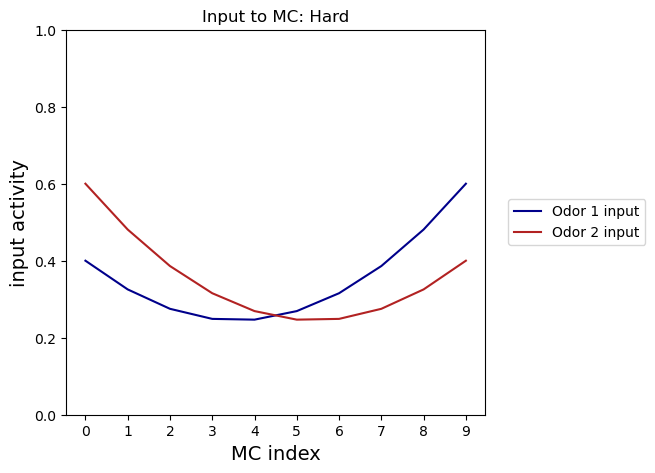

In [ ]:
fig, ax = plt.subplots(figsize = (6,5))
plt.plot(odor_mixes[0], color = 'darkblue', label = 'Odor 1 input')
plt.plot(odor_mixes[1], color  = 'firebrick', label = 'Odor 2 input')
plt.xticks(list(range(10)))
ax.set_xlabel('MC index', fontsize = 14)
ax.set_ylabel('input activity', fontsize = 14)
ax.set_title('Input to MC: Hard')
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax.set_ylim([0, 1])
plt.show()

In [16]:
K = 500
GC_acts_overtime_hard, MC_errs_overtime_hard, W_overtime_hard =  main(W_hard, odor_mixes, theta, K) 

One completely got left not touched

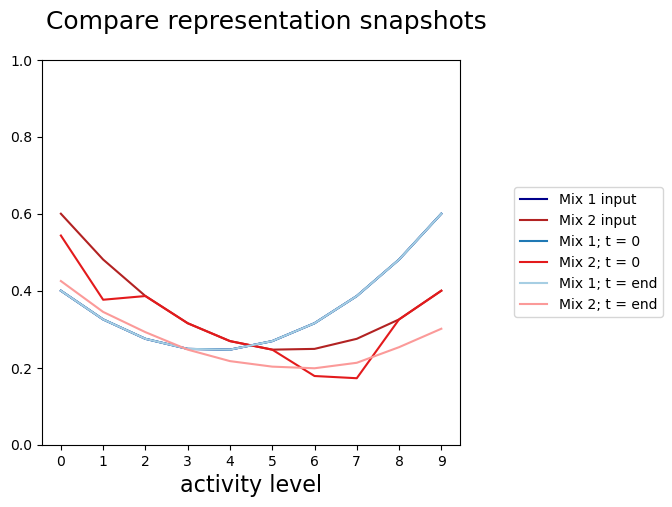

In [69]:
fig, ax = plt.subplots(figsize = (6,5))
plt.plot(odor_mixes[:, 0], color = 'darkblue', 
         label = 'Mix 1 input')
plt.plot(odor_mixes[:, 1], color  = 'firebrick', 
         label = 'Mix 2 input')

plt.plot(MC_errs_overtime_hard[0,:, 0], 
         label = 'Mix 1; t = 0', 
         color = sns.color_palette("Paired")[1])
plt.plot(MC_errs_overtime_hard[0,:, 1], 
         label = 'Mix 2; t = 0', 
         color = sns.color_palette("Paired")[5])

plt.plot(MC_errs_overtime_hard[499,:, 0], 
         label = 'Mix 1; t = end',
         color = sns.color_palette("Paired")[0])
plt.plot(MC_errs_overtime_hard[499,:, 1],  
         label = 'Mix 2; t = end', 
         color = sns.color_palette("Paired")[4])

plt.xticks(list(range(10)))
plt.xlabel('MC index', fontsize = 16)
plt.xlabel('activity level', fontsize = 16)

plt.ylim([0, 1])
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.suptitle('Compare representation snapshots', fontsize = 18)
plt.show()

fig.savefig('snapshots_hard.pdf')

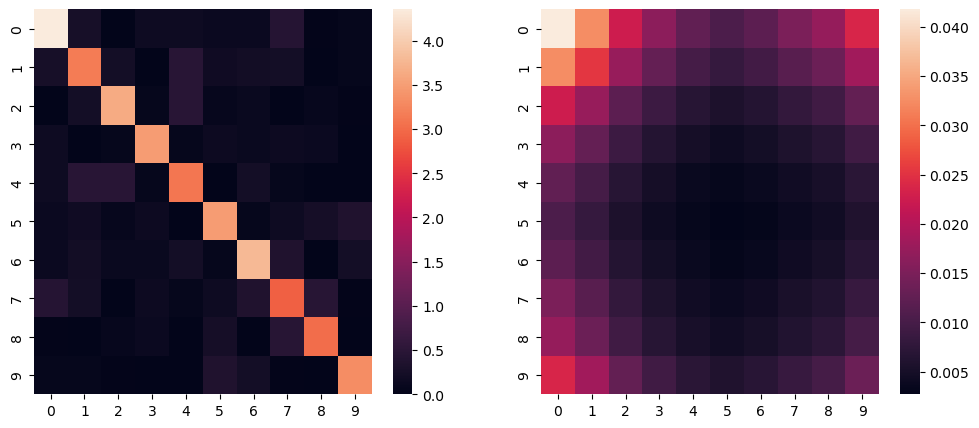

In [70]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 5))
sns.heatmap(W@W.T, ax = ax[0])
sns.heatmap(W_overtime_hard[-1]@W_overtime_hard[-1].T, ax = ax[1])
plt.show()

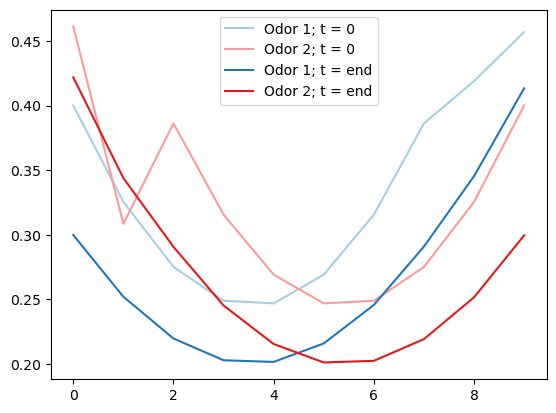

In [129]:
plt.plot(MC_errs_overtime_hard[0,:, 0], 
         label = 'Odor 1; t = 0', 
         color = sns.color_palette("Paired")[0])
plt.plot(MC_errs_overtime_hard[0,:, 1], 
         label = 'Odor 2; t = 0', 
         color = sns.color_palette("Paired")[4])
plt.plot(MC_errs_overtime_hard[499,:, 0], 
         label = 'Odor 1; t = end',
         color = sns.color_palette("Paired")[1])
plt.plot(MC_errs_overtime_hard[499,:, 1],  
         label = 'Odor 2; t = end', 
         color = sns.color_palette("Paired")[5])
plt.legend()
plt.show()

/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

<Axes: >

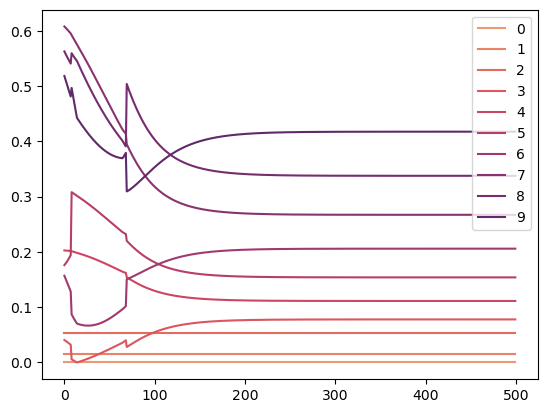

In [133]:
sns.lineplot(MC_errs_overtime[:,:, 0], dashes = False, palette = 'flare')

/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

<Axes: >

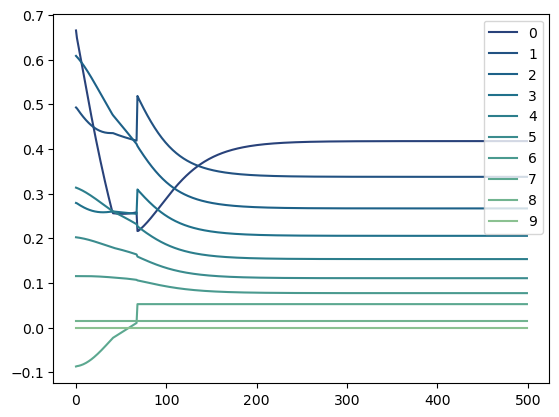

In [131]:
sns.lineplot(MC_errs_overtime[:,:, 1], dashes = False, palette = 'crest_r')

In [134]:
absolute_diff_hard = np.abs(MC_errs_overtime_hard[:,:, 0] - MC_errs_overtime_hard[:,:, 1])

/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

<Axes: >

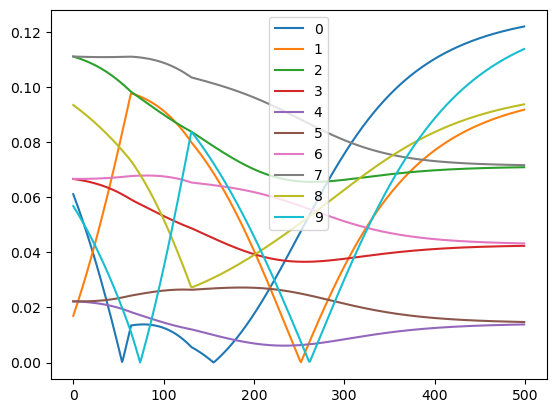

In [135]:
sns.lineplot(absolute_diff_hard, dashes = False)

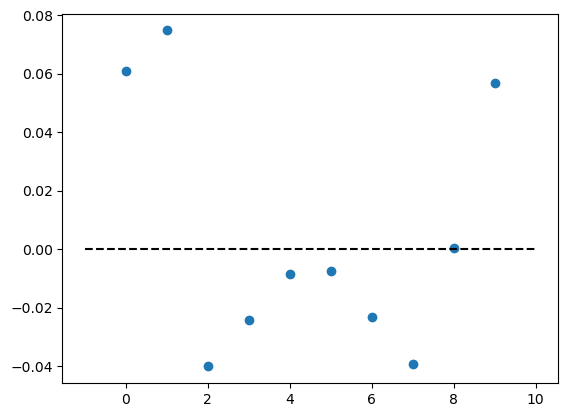

In [148]:
plt.scatter(list(range(M)), absolute_diff_hard[-1]- absolute_diff_hard[0])
plt.hlines(y = 0, xmin = -1, xmax = 10, linestyle = '--', color = 'black')

what about distance?

In [141]:
dists_hard = np.linalg.norm(x = MC_errs_overtime_hard[:, :, 0] - MC_errs_overtime_hard[:, :, 1], axis = 1)

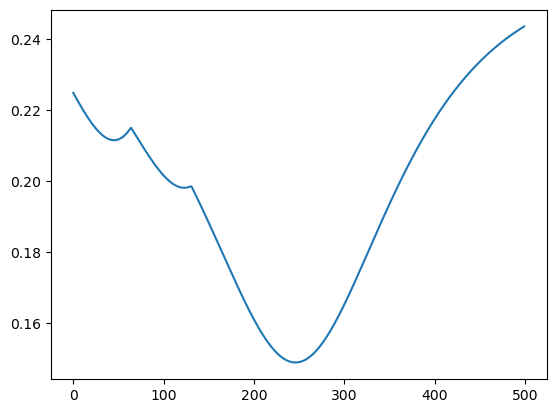

In [143]:
plt.plot(dists_hard)
plt.show()

In [144]:
dists = np.linalg.norm(x = MC_errs_overtime[:, :, 0] - MC_errs_overtime[:, :, 1], axis = 1)

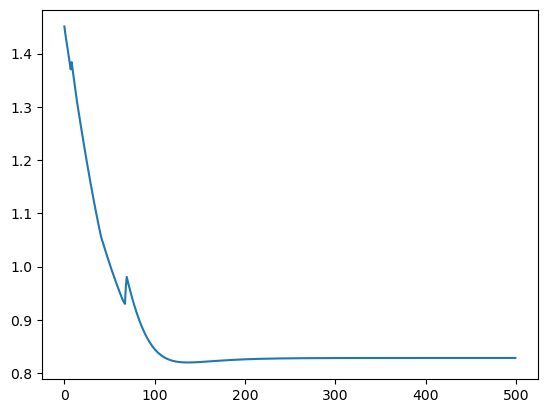

In [146]:
plt.plot(dists)
plt.show()

In [156]:
import math_utils

angles_hard= []
angles = []
for k in range(K//2):  
    sim, angle = math_utils.cos_sim(MC_errs_overtime_hard[k, :, 0], MC_errs_overtime_hard[k, :, 1])
    angles_hard.append(angle)
    sim, angle = math_utils.cos_sim(MC_errs_overtime[k, :, 0], MC_errs_overtime[k, :, 1])
    angles.append(angle)


do something to GCs!

In [159]:
counts = []
counts_hard = []

for k in range(K//2):  
    count = math_utils.shared_GCcount(GC_acts_overtime[k])
    counts.append(count)
    count = math_utils.shared_GCcount(GC_acts_overtime_hard[k])
    counts_hard.append(count)

In [166]:
GC_acts_overtime[0].shape

(750, 2)

In [ ]:
# # display the averaged 30 stimuli: 
# plot_learning(GC_responpse_easy_init, odors_easy, W, t = 0)
# clear_output(wait=True)

# for k in range(0, K, 25):
#     plot_learning(GC_acts_overtime_easy[k], MC_errs_overtime_easy[k], W_overtime_easy[k*2], t = k + 1)
#     clear_output(wait=True)

In [24]:
# plot_learning(GC_responpse_easy_init, odors_easy, W, t = 0, odor_type = 'Odor')
# clear_output(wait=True)

# for k in range(0, K, 25):
#     plot_learning(GC_acts_overtime_easy[k], MC_errs_overtime_easy[k], W_overtime_easy[k*2], t = k + 1, odor_type = 'Odor')
#     clear_output(wait=True)

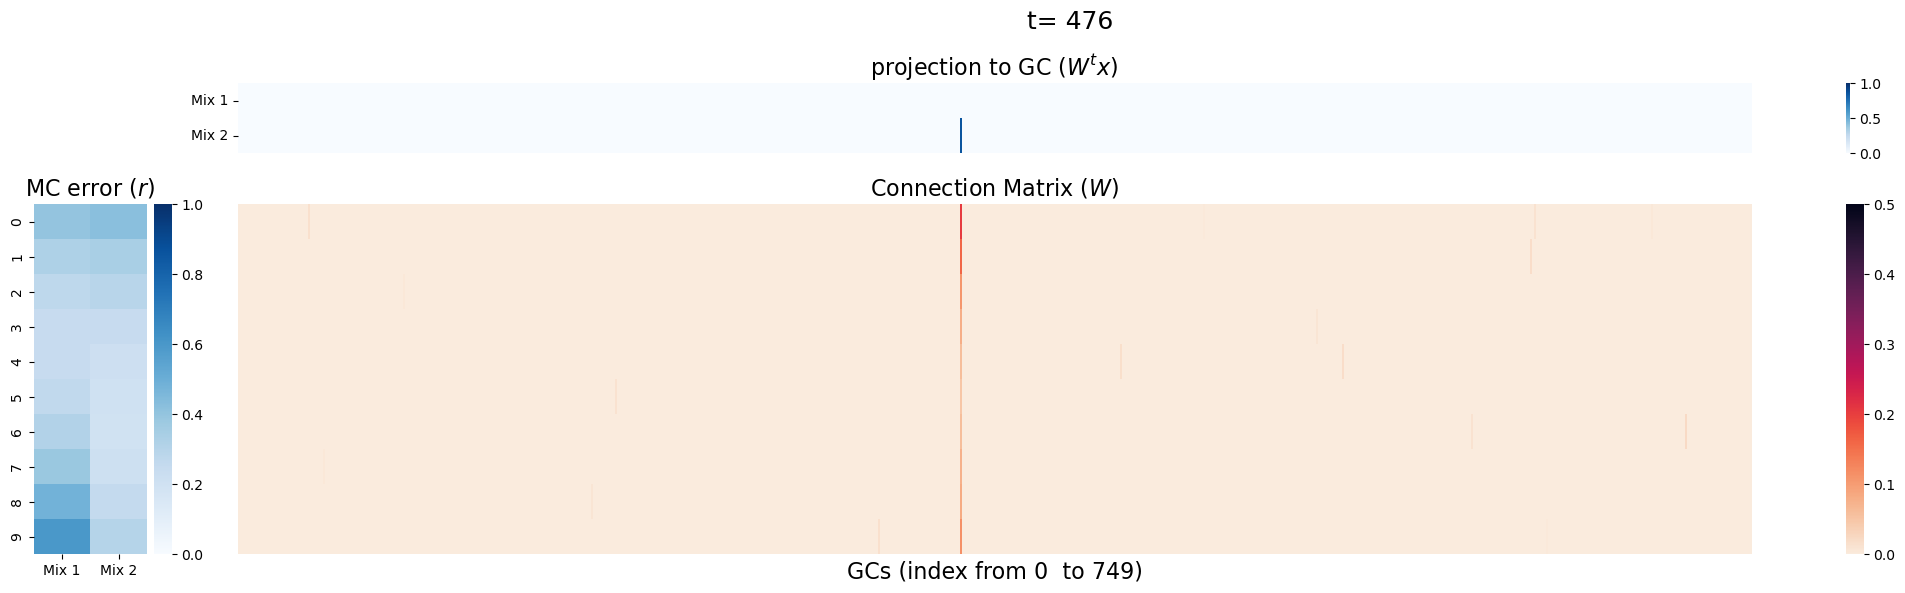

In [29]:
plot_learning(GC_responpse_hard_init, odor_mixes, W, t = 0, odor_type = 'Mix')
clear_output(wait=True)

for k in range(0, K, 25):
    plot_learning(GC_acts_overtime_hard[k], MC_errs_overtime_hard[k], W_overtime_hard[k*2], t = k + 1, odor_type = 'Mix')
    clear_output(wait=True)